In [1]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import pickle

# --- CONFIGURATION ---
# 10 mins = 144 steps in 24 hours (24 * 60 / 10)
BIN_SIZE = '10min' 
EXPECTED_STEPS = 144 

# Paths (Based on your download structure)
INPUT_FILE = "data/Sample_2/chartevents_vaso_24h_post.csv.gz"
OUTPUT_TENSOR = "data/Sample_2/tensor_10min_24h.pkl"
OUTPUT_IDS = "data/Sample_2/tensor_stay_ids.pkl"

# 1. Load Data (Optimized)
print("⏳ Loading data... (this takes ~30-60s)")
try:
    df = pd.read_csv(
        INPUT_FILE, 
        compression="gzip",
        usecols=["stay_id", "itemid", "valuenum", "hours_since_vaso"],
        dtype_backend="pyarrow" # drastically reduces RAM usage
    )
except ValueError:
    # Fallback if pyarrow isn't installed/supported
    df = pd.read_csv(
        INPUT_FILE, 
        compression="gzip",
        usecols=["stay_id", "itemid", "valuenum", "hours_since_vaso"]
    )

print(f"✅ Loaded {len(df):,} rows.")

# 2. Map ItemIDs to Names
# (Recreating the dictionary from your d_items file to be safe)
d_items = pd.read_csv("data/Sample_2/d_items.csv.gz")
# Simple regex map for the 7 key vitals
pattern_map = {
    r"Heart Rate|HR": "HR",
    r"Respiratory Rate|RR": "RR",
    r"O2 saturation|SpO2": "SpO2",
    r"Mean Arterial Pressure|MAP|ABP mean": "MAP",
    r"Systolic.*Blood Pressure|NBP systolic|NIBP systolic": "SBP",
    r"Diastolic.*Blood Pressure|NBP diastolic|NIBP diastolic": "DBP",
    r"Temperature|Temp": "Temp",
}
def get_signal(label):
    for pat, sig in pattern_map.items():
        if pd.notna(label) and pd.Series(label).str.contains(pat, case=False, regex=True).any():
            return sig
    return None

# Create mapping dict
d_items['signal'] = d_items['label'].apply(get_signal)
item_map = d_items.dropna(subset=['signal']).set_index('itemid')['signal'].to_dict()

# Apply map & drop unused rows
df['signal'] = df['itemid'].map(item_map)
df = df.dropna(subset=['signal'])

# 3. Convert time to Timedelta
df['time_delta'] = pd.to_timedelta(df['hours_since_vaso'], unit='h')

# 4. Resample (The Heavy Lift)
print("⏳ Resampling to 10-min bins... (this takes ~2-3 mins)")

def process_stay(group):
    # Pivot: Index=Time, Columns=Signals
    # aggfunc='mean' handles multiple readings in same 10-min window
    wide = group.pivot_table(index='time_delta', columns='signal', values='valuenum', aggfunc='mean')
    
    # Force fixed grid (0h to 24h)
    full_idx = pd.timedelta_range(start='0h', end='24h', freq=BIN_SIZE, closed='left')
    wide = wide.reindex(full_idx)
    
    # Forward Fill (carry last reading forward 1 hour max), then Backfill
    wide = wide.ffill(limit=6).bfill()
    
    # Ensure we always return exactly 144 rows
    return wide.iloc[:EXPECTED_STEPS]

# Groupby apply is safer for memory than a full pivot
tensor_df = df.groupby('stay_id').apply(process_stay)

# 5. Formatting for Model
# We need a 3D numpy array: (N_patients, 144, 7)
unique_stays = tensor_df.index.get_level_values(0).unique()
n_samples = len(unique_stays)
n_features = len(tensor_df.columns)

# Convert to numpy 3D array
X_tensor = tensor_df.values.reshape(n_samples, EXPECTED_STEPS, n_features)

# Save
with open(OUTPUT_TENSOR, 'wb') as f:
    pickle.dump(X_tensor, f)
with open(OUTPUT_IDS, 'wb') as f:
    pickle.dump(unique_stays.values, f)

print("-" * 30)
print(f"✅ TENSOR BUILT SUCCESSFULLY")
print(f"Shape: {X_tensor.shape} (Patients, TimeSteps, Features)")
print(f"Features order: {list(tensor_df.columns)}")
print(f"Saved to: {OUTPUT_TENSOR}")

⏳ Loading data... (this takes ~30-60s)
✅ Loaded 41,663,872 rows.
⏳ Resampling to 10-min bins... (this takes ~2-3 mins)


/var/tmp/ipykernel_4594/1940551331.py:83: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tensor_df = df.groupby('stay_id').apply(process_stay)


------------------------------
✅ TENSOR BUILT SUCCESSFULLY
Shape: (28735, 144, 5) (Patients, TimeSteps, Features)
Features order: ['HR', 'RR', 'SpO2', 'Temp', 'MAP']
Saved to: data/Sample_2/tensor_10min_24h.pkl


In [6]:
import pandas as pd
import pickle
import numpy as np

# 1. Load the IDs that made it into the Tensor
# (We must match this order exactly)
with open("data/Sample_2/tensor_stay_ids.pkl", 'rb') as f:
    tensor_ids = pickle.load(f)

print(f"Tensor IDs loaded: {len(tensor_ids)}")

# 2. Load your Labeled Dataset
# This file contains the 'hypotension_label' (0 or 1)
labels_df = pd.read_csv(
    "data/Sample_2/merged_features_labeled_clean.csv.gz",
    usecols=["stay_id", "hypotension_label"]
)

# 3. Align Labels to Tensor
# Create a DataFrame indexed by the exact tensor ID order
tensor_order = pd.DataFrame({"stay_id": tensor_ids})
aligned_df = tensor_order.merge(labels_df, on="stay_id", how="left")

# 4. Check for Missing Labels
missing = aligned_df["hypotension_label"].isna().sum()
print(f"Missing labels: {missing}")

# Fill NaN labels if any (rare edge case) or drop
if missing > 0:
    print("⚠️ Warning: Some tensor IDs have no label. Filling with 0 (Non-Hypotensive) for now.")
    aligned_df["hypotension_label"] = aligned_df["hypotension_label"].fillna(0)

# 5. Save as Numpy Array 'y'
y = aligned_df["hypotension_label"].values.astype(int)
with open("data/Sample_2/y_labels.pkl", 'wb') as f:
    pickle.dump(y, f)

print("-" * 30)
print(f"✅ LABELS ALIGNED & SAVED")
print(f"Shape: {y.shape}")
print(f"Class Balance: {np.unique(y, return_counts=True)}")

Tensor IDs loaded: 28735
Missing labels: 8422
⚠️ Warning: Some tensor IDs have no label. Filling with 0 (Non-Hypotensive) for now.
------------------------------
✅ LABELS ALIGNED & SAVED
Shape: (28735,)
Class Balance: (array([0, 1]), array([12026, 16709]))


In [7]:
import pandas as pd
import pickle
import os

# --- CONFIGURATION ---
# Updated to point to the correct "_vaso" file you created earlier
INPUT_ICU = "data/Sample_2/icustays_vaso.csv.gz" 

# These two files must be downloaded from your source (Drive/PhysioNet) 
# and placed in data/Sample_2/ manually, as they weren't part of the vaso-sampling pipeline.
INPUT_PATIENTS = "data/Sample_2/patients.csv.gz" 
INPUT_ADMISSIONS = "data/Sample_2/admissions.csv.gz"
OUTPUT_STATIC = "data/Sample_2/static_fairness_data.csv.gz"

# 1. Load Data
# We only need the cohort that made it into our Tensor
tensor_ids_path = "data/Sample_2/tensor_stay_ids.pkl"

if not os.path.exists(tensor_ids_path):
    raise FileNotFoundError("❌ tensor_stay_ids.pkl not found. Run the Time-Series Tensor script first.")

with open(tensor_ids_path, 'rb') as f:
    valid_stay_ids = pickle.load(f)

print(f"⏳ Building static features for {len(valid_stay_ids)} patients...")

# Load ICU stays (using the vaso filtered file)
icu = pd.read_csv(INPUT_ICU, compression='gzip', usecols=['stay_id', 'subject_id', 'hadm_id'])
icu = icu[icu['stay_id'].isin(valid_stay_ids)]

# 2. Merge Demographics
if os.path.exists(INPUT_PATIENTS) and os.path.exists(INPUT_ADMISSIONS):
    print("✅ Demographic files found. Merging...")
    pat = pd.read_csv(INPUT_PATIENTS, compression='gzip', usecols=['subject_id', 'gender', 'anchor_age'])
    adm = pd.read_csv(INPUT_ADMISSIONS, compression='gzip', usecols=['subject_id', 'hadm_id', 'race'])
    
    # Merge
    static = icu.merge(pat, on='subject_id', how='left')
    static = static.merge(adm, on=['subject_id', 'hadm_id'], how='left')
    
    # 3. Encode for Model
    # Gender: Male=1, Female=0
    static['is_male'] = (static['gender'] == 'M').astype(int)
    
    # Race: Simplify to top groups for fairness analysis
    def clean_race(r):
        if pd.isna(r): return 0 # Other/Unknown
        r = r.upper()
        if 'WHITE' in r: return 1
        if 'BLACK' in r: return 2
        if 'HISPANIC' in r: return 3
        if 'ASIAN' in r: return 4
        return 0
    
    static['race_enc'] = static['race'].apply(clean_race)
    
    # Save
    static.to_csv(OUTPUT_STATIC, index=False, compression='gzip')
    print(f"✅ Static features saved to: {OUTPUT_STATIC}")
    print("-" * 30)
    print("Preview of Static Data:")
    print(static[['stay_id', 'anchor_age', 'is_male', 'race_enc']].head())

else:
    print("❌ ERROR: Missing demographic files.")
    print(f"Please download 'patients.csv.gz' and 'admissions.csv.gz' and upload them to: {os.path.abspath('data/Sample_2/')}")

⏳ Building static features for 28735 patients...
✅ Demographic files found. Merging...
✅ Static features saved to: data/Sample_2/static_fairness_data.csv.gz
------------------------------
Preview of Static Data:
    stay_id  anchor_age  is_male  race_enc
0  37081114          86        0         1
1  37510196          68        0         2
2  39060235          53        0         0
3  34672098          56        1         0
4  35479615          80        0         1


In [10]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.4/620.4 MB 62.8 MB/s  0:00:07m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 104.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 116.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 109.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 73.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 128.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17/17 [tensorflow]7 [tensorflow]]]ata-server]


In [14]:
# ==========================================
# 1. LOAD AND PREPROCESS DATA (Final Fix)
# ==========================================
print("⏳ Loading data...")
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Load Time-Series (X_dynamic)
with open(TENSOR_PATH, 'rb') as f:
    X_dynamic = pickle.load(f)

# --- FIX: Force conversion to numeric using 'coerce' ---
# 1. Flatten to 2D
n_samples, n_steps, n_features = X_dynamic.shape
X_flat = X_dynamic.reshape(-1, n_features)

# 2. Use apply(pd.to_numeric) with errors='coerce'
# This forces stubborn 'pd.NA' types into standard 'np.nan' (float)
X_flat = pd.DataFrame(X_flat).apply(pd.to_numeric, errors='coerce').values.astype(np.float32)

# 3. Impute (Fill NaNs)
# Neural networks cannot handle NaNs. We fill gaps with the column mean.
imputer = SimpleImputer(strategy='mean')
X_flat = imputer.fit_transform(X_flat)

# 4. Scale (Standardize)
scaler_dynamic = StandardScaler()
X_flat = scaler_dynamic.fit_transform(X_flat)

# 5. Reshape back to 3D
X_dynamic = X_flat.reshape(n_samples, n_steps, n_features)

# Load Labels (y)
with open(LABEL_PATH, 'rb') as f:
    y = pickle.load(f)

# Load Static Features (X_static)
static_df = pd.read_csv(STATIC_PATH)

# Apply the same numeric coercion to static features just to be safe
X_static = static_df[['anchor_age', 'is_male', 'race_enc']].apply(pd.to_numeric, errors='coerce').values.astype(np.float32)

# Impute static data (in case of missing ages/demographics)
X_static = imputer.fit_transform(X_static)

# --- Data Alignment Check ---
print(f"Dimensions Check: Tensor={X_dynamic.shape[0]}, Static={X_static.shape[0]}, Labels={y.shape[0]}")
if not (X_dynamic.shape[0] == y.shape[0] == X_static.shape[0]):
    raise ValueError("❌ Data dimension mismatch! Your Tensor, Labels, and Static data must have the same number of patients.")

# --- Train/Test Split ---
X_dyn_train, X_dyn_test, X_stat_train, X_stat_test, y_train, y_test = train_test_split(
    X_dynamic, X_static, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Data Ready. Training on {X_dyn_train.shape[0]} samples, Testing on {X_dyn_test.shape[0]}.")
print(f"Check for NaNs: {np.isnan(X_dyn_train).sum()} (Should be 0)")

⏳ Loading data...
Dimensions Check: Tensor=28735, Static=28735, Labels=28735
✅ Data Ready. Training on 22988 samples, Testing on 5747.
Check for NaNs: 0 (Should be 0)


In [15]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ==========================================
# 2. CALCULATE CLASS WEIGHTS
# ==========================================
# This balances the loss function so the model doesn't just predict the majority class
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"⚖️ Class Weights: {class_weight_dict}")
# You will likely see {0: ~2.8, 1: ~0.6} because Stable (0) is rare in this cohort.


# ==========================================
# 3. BUILD THE HYBRID TRANSFORMER ARCHITECTURE
# ==========================================
def build_hybrid_transformer(input_shape_dyn, input_shape_stat):
    # --- Branch A: Time-Series (The "Movie") ---
    input_dynamic = keras.Input(shape=input_shape_dyn, name="time_series_input")
    
    # 1. Transformer Block
    # Self-Attention: Finds relationships between different time steps (e.g., Hour 2 vs Hour 23)
    attention_output = layers.MultiHeadAttention(
        num_heads=4, key_dim=32, dropout=0.1
    )(input_dynamic, input_dynamic)
    
    # Add & Normalize (Standard Deep Learning stabilization)
    x1 = layers.Add()([input_dynamic, attention_output])
    x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
    
    # Feed Forward Network (The "Reasoning" part)
    x2 = layers.Conv1D(filters=64, kernel_size=1, activation="relu")(x1)
    x2 = layers.Dropout(0.1)(x2)
    x2 = layers.Conv1D(filters=input_shape_dyn[-1], kernel_size=1)(x2)
    
    # Add & Normalize again
    transformer_output = layers.Add()([x1, x2])
    transformer_output = layers.LayerNormalization(epsilon=1e-6)(transformer_output)
    
    # Global Pooling: Squashes 144 time steps into one summary vector
    dynamic_features = layers.GlobalAveragePooling1D()(transformer_output)

    # --- Branch B: Static Features (The "Context") ---
    # Processes Age, Gender, Race
    input_static = keras.Input(shape=input_shape_stat, name="static_input")
    x_static = layers.Dense(16, activation="relu")(input_static)
    
    # --- Fusion Layer ---
    # Concatenate (glue) the dynamic summary and static context together
    concat = layers.Concatenate()([dynamic_features, x_static])
    
    # Final Decision Layers
    x = layers.Dense(32, activation="relu")(concat)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(1, activation="sigmoid", name="prediction")(x)

    # Compile Model
    model = keras.Model(inputs=[input_dynamic, input_static], outputs=output)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Conservative learning rate
        loss="binary_crossentropy",
        metrics=["AUC", "accuracy"] # AUC is our primary research metric
    )
    return model

# Construct the model instance
model = build_hybrid_transformer(
    input_shape_dyn=(X_dyn_train.shape[1], X_dyn_train.shape[2]), # (144, 5)
    input_shape_stat=(X_stat_train.shape[1],)                     # (3,)
)

print("\nModel Architecture:")
model.summary()

# ==========================================
# 4. TRAIN THE MODEL
# ==========================================
print("\n🚀 Starting Training...")
history = model.fit(
    x=[X_dyn_train, X_stat_train],   # Two inputs: Dynamic + Static
    y=y_train,
    validation_data=([X_dyn_test, X_stat_test], y_test),
    epochs=20,
    batch_size=64,
    class_weight=class_weight_dict,  # Apply the weights we calculated
    callbacks=[
        # Stop if validation AUC doesn't improve for 5 epochs
        keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)
    ],
    verbose=1
)

print("✅ Training Complete.")

⚖️ Class Weights: {0: 1.194678307868205, 1: 0.8598788060148126}

Model Architecture:


2025-11-19 23:27:34.099113: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_series_input   │ (None, 144, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 5)    │      2,949 │ time_series_inpu… │
│ (MultiHeadAttentio… │                   │            │ time_series_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 144, 5)    │          0 │ time_series_inpu… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 144, 5)    │         10 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 144, 64)   │        384 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 144, 64)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 144, 5)    │        325 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 144, 5)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 5)    │         10 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 5)         │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │         64 │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 21)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        704 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction (Dense)  │ (None, 1)         │         33 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,479 (17.50 KB)

 Trainable params: 4,479 (17.50 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Starting Training...
Epoch 1/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 64s 167ms/step - AUC: 0.5090 - accuracy: 0.5346 - loss: 4.1087 - val_AUC: 0.5344 - val_accuracy: 0.4773 - val_loss: 0.7348
Epoch 2/20
  1/360 ━━━━━━━━━━━━━━━━━━━━ 1:03 176ms/step - AUC: 0.5325 - accuracy: 0.4688 - loss: 2.8624

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 59s 165ms/step - AUC: 0.5048 - accuracy: 0.5031 - loss: 2.6687 - val_AUC: 0.5440 - val_accuracy: 0.4743 - val_loss: 0.7250
Epoch 3/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 59s 165ms/step - AUC: 0.5007 - accuracy: 0.4998 - loss: 2.1707 - val_AUC: 0.5582 - val_accuracy: 0.4764 - val_loss: 0.7083
Epoch 4/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 60s 167ms/step - AUC: 0.5038 - accuracy: 0.5022 - loss: 1.6744 - val_AUC: 0.5715 - val_accuracy: 0.5117 - val_loss: 0.6885
Epoch 5/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 60s 165ms/step - AUC: 0.5073 - accuracy: 0.5071 - loss: 1.2888 - val_AUC: 0.5773 - val_accuracy: 0.4963 - val_loss: 0.6914
Epoch 6/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 60s 167ms/step - AUC: 0.5186 - accuracy: 0.5178 - loss: 1.0029 - val_AUC: 0.5893 - val_accuracy: 0.5018 - val_loss: 0.6869
Epoch 7/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 60s 166ms/step - AUC: 0.5280 - accuracy: 0.5189 - loss: 0.8210 - val_AUC: 0.5886 - val_accuracy: 0.5465 - val_loss: 0.6762
Epoch 8/20
360/360 ━━━━━━━━━━━━━━

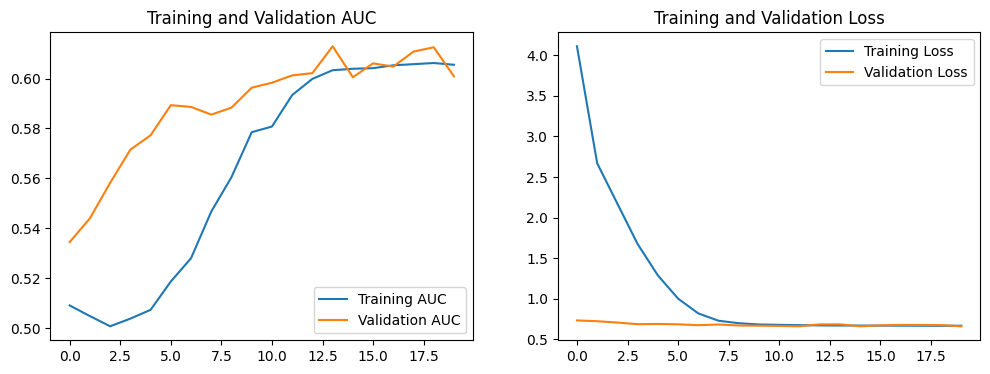


🔍 RUNNING FAIRNESS ANALYSIS...

📊 FAIRNESS REPORT (Transformer Model)
------------------------------------------------------------
| Subgroup       |    N |   AUC |   FPR (False Alarm) |   FNR (Missed Case) |
|:---------------|-----:|------:|--------------------:|--------------------:|
| OVERALL        | 5747 | 0.601 |               0.741 |               0.186 |
| Gender: Male   | 3472 | 0.612 |               0.734 |               0.188 |
| Gender: Female | 2275 | 0.582 |               0.751 |               0.183 |
| Race: White    | 3850 | 0.603 |               0.76  |               0.176 |
| Race: Black    |  462 | 0.576 |               0.704 |               0.218 |
| Race: Hispanic |  213 | 0.62  |               0.698 |               0.213 |
| Race: Asian    |  164 | 0.596 |               0.671 |               0.239 |
------------------------------------------------------------


In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix

# ==========================================
# 1. VISUALIZE LEARNING CURVES
# ==========================================
def plot_history(history):
    acc = history.history['AUC']
    val_acc = history.history['val_AUC']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    
    # Plot AUC
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training AUC')
    plt.plot(epochs_range, val_acc, label='Validation AUC')
    plt.legend(loc='lower right')
    plt.title('Training and Validation AUC')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Plot the curves from your training variable 'history'
plot_history(history)

# ==========================================
# 2. FAIRNESS ANALYSIS (The Research Gap)
# ==========================================
print("\n🔍 RUNNING FAIRNESS ANALYSIS...")

# A. Get Predictions
# We use the test set we created earlier (X_dyn_test, X_stat_test, y_test)
y_pred_proba = model.predict([X_dyn_test, X_stat_test], verbose=0).flatten()
# Threshold: You can lower this to 0.3 or 0.4 later to catch more cases
y_pred = (y_pred_proba >= 0.5).astype(int) 

# B. Reconstruct the Test DataFrame
# We need to know WHICH patient belongs to WHICH demographic in the test set
# We can reverse-engineer this from X_stat_test
# X_stat_test columns: [0: Age (Scaled), 1: Is_Male, 2: Race_Enc]

test_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'y_proba': y_pred_proba,
    'is_male': X_stat_test[:, 1],
    'race_enc': X_stat_test[:, 2]
})

# Decode Race (0=Other, 1=White, 2=Black, 3=Hispanic, 4=Asian)
race_map = {0: 'Other/Unknown', 1: 'White', 2: 'Black', 3: 'Hispanic', 4: 'Asian'}
test_df['Race'] = test_df['race_enc'].map(race_map)

# Decode Gender
test_df['Gender'] = test_df['is_male'].apply(lambda x: 'Male' if x == 1 else 'Female')

# C. Define Metrics Function
def get_metrics(df_sub):
    if len(df_sub) == 0: return {'N': 0}
    y_t = df_sub['y_true']
    y_p = df_sub['y_pred']
    
    try:
        auc = roc_auc_score(y_t, df_sub['y_proba'])
    except:
        auc = 0.0 # Handle edge case if only 1 class exists
        
    tn, fp, fn, tp = confusion_matrix(y_t, y_p, labels=[0,1]).ravel()
    
    # False Positive Rate (False Alarm Rate) = FP / (FP + TN)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # False Negative Rate (Missed Diagnosis Rate) = FN / (FN + TP)
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    return {
        'N': len(df_sub),
        'AUC': round(auc, 3),
        'FPR (False Alarm)': round(fpr, 3),
        'FNR (Missed Case)': round(fnr, 3)
    }

# D. Analyze by Subgroup
results = []

# Overall
results.append({'Subgroup': 'OVERALL', **get_metrics(test_df)})

# By Gender
for g in ['Male', 'Female']:
    sub = test_df[test_df['Gender'] == g]
    results.append({'Subgroup': f'Gender: {g}', **get_metrics(sub)})

# By Race
for r in ['White', 'Black', 'Hispanic', 'Asian']:
    sub = test_df[test_df['Race'] == r]
    results.append({'Subgroup': f'Race: {r}', **get_metrics(sub)})

# E. Display
results_df = pd.DataFrame(results)
print("\n📊 FAIRNESS REPORT (Transformer Model)")
print("-" * 60)
print(results_df[['Subgroup', 'N', 'AUC', 'FPR (False Alarm)', 'FNR (Missed Case)']].to_markdown(index=False))
print("-" * 60)

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ==========================================
# 1. DEFINE FOCAL LOSS
# ==========================================
# Gamma=2.0 focuses heavily on hard examples. Alpha=0.25 balances the classes.
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = keras.backend.epsilon()
        y_pred = keras.backend.clip(y_pred, epsilon, 1.0 - epsilon)
        
        y_true = tf.cast(y_true, tf.float32)
        
        alpha_t = y_true * alpha + (keras.backend.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (keras.backend.ones_like(y_true) - y_true) * (1 - y_pred)
        fl = - alpha_t * keras.backend.pow((keras.backend.ones_like(y_true) - p_t), gamma) * keras.backend.log(p_t)
        
        return keras.backend.mean(fl)
    return focal_loss_fixed

# ==========================================
# 2. BUILD IMPROVED TRANSFORMER (V2)
# ==========================================
def build_improved_transformer(input_shape_dyn, input_shape_stat):
    # --- Branch A: Time-Series ---
    input_dynamic = keras.Input(shape=input_shape_dyn, name="time_series_input")
    
    x = input_dynamic
    
    # Stack 2 Transformer Blocks for deeper learning
    for i in range(2):
        # Multi-Head Attention
        attention_output = layers.MultiHeadAttention(
            num_heads=4, key_dim=32, dropout=0.1
        )(x, x)
        
        # Add & Norm
        x1 = layers.Add()([x, attention_output])
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        
        # Feed Forward
        x2 = layers.Conv1D(filters=64, kernel_size=1, activation="relu")(x1)
        x2 = layers.Dropout(0.1)(x2)
        x2 = layers.Conv1D(filters=input_shape_dyn[-1], kernel_size=1)(x2)
        
        # Add & Norm
        x = layers.Add()([x1, x2])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Global Pooling
    dynamic_features = layers.GlobalAveragePooling1D()(x)

    # --- Branch B: Static Features ---
    input_static = keras.Input(shape=input_shape_stat, name="static_input")
    x_static = layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(input_static)
    
    # --- Fusion ---
    concat = layers.Concatenate()([dynamic_features, x_static])
    
    # Deeper Classification Head
    x = layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(concat)
    x = layers.Dropout(0.3)(x) # Higher dropout to prevent overfitting
    x = layers.Dense(32, activation="relu")(x)
    
    output = layers.Dense(1, activation="sigmoid", name="prediction")(x)

    model = keras.Model(inputs=[input_dynamic, input_static], outputs=output)
    
    # Compile with FOCAL LOSS (No class_weights needed in .fit() if we use this)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005), # Slightly higher LR for focal loss
        loss=binary_focal_loss(gamma=2.0, alpha=0.20), # Alpha < 0.5 penalizes majority class
        metrics=["AUC", "accuracy"]
    )
    return model

# Build
model_v2 = build_improved_transformer(
    input_shape_dyn=(X_dyn_train.shape[1], X_dyn_train.shape[2]),
    input_shape_stat=(X_stat_train.shape[1],)
)

model_v2.summary()

# ==========================================
# 3. TRAIN V2 MODEL
# ==========================================
print("\n🚀 Starting Training (V2 with Focal Loss)...")
# Note: We REMOVE class_weights because Focal Loss handles the imbalance internally
history_v2 = model_v2.fit(
    x=[X_dyn_train, X_stat_train],
    y=y_train,
    validation_data=([X_dyn_test, X_stat_test], y_test),
    epochs=25, # Give it a bit more time
    batch_size=64,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', patience=6, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_AUC', factor=0.5, patience=3, verbose=1)
    ],
    verbose=1
)

print("✅ V2 Training Complete.")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_series_input   │ (None, 144, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 5)    │      2,949 │ time_series_inpu… │
│ (MultiHeadAttentio… │                   │            │ time_series_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 144, 5)    │          0 │ time_series_inpu… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 5)    │         10 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 144, 64)   │        384 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 144, 64)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 144, 5)    │        325 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 144, 5)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 5)    │         10 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 5)    │      2,949 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 144, 5)    │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 5)    │         10 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 144, 64)   │        384 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 144, 64)   │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 144, 5)    │        325 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 144, 5)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 5)    │         10 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 5)         │          0 │ layer_normalizat

 Total params: 10,941 (42.74 KB)

 Trainable params: 10,941 (42.74 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Starting Training (V2 with Focal Loss)...
Epoch 1/25
360/360 ━━━━━━━━━━━━━━━━━━━━ 128s 334ms/step - AUC: 0.5060 - accuracy: 0.4543 - loss: 0.1520 - val_AUC: 0.4859 - val_accuracy: 0.4185 - val_loss: 0.0813 - learning_rate: 5.0000e-04
Epoch 2/25
360/360 ━━━━━━━━━━━━━━━━━━━━ 120s 333ms/step - AUC: 0.4989 - accuracy: 0.4239 - loss: 0.0822 - val_AUC: 0.5025 - val_accuracy: 0.4185 - val_loss: 0.0765 - learning_rate: 5.0000e-04
Epoch 3/25
360/360 ━━━━━━━━━━━━━━━━━━━━ 120s 333ms/step - AUC: 0.4993 - accuracy: 0.4206 - loss: 0.0760 - val_AUC: 0.5038 - val_accuracy: 0.4185 - val_loss: 0.0733 - learning_rate: 5.0000e-04
Epoch 4/25
360/360 ━━━━━━━━━━━━━━━━━━━━ 122s 338ms/step - AUC: 0.5105 - accuracy: 0.4193 - loss: 0.0733 - val_AUC: 0.5508 - val_accuracy: 0.4185 - val_loss: 0.0715 - learning_rate: 5.0000e-04
Epoch 5/25
360/360 ━━━━━━━━━━━━━━━━━━━━ 123s 341ms/step - AUC: 0.5415 - accuracy: 0.4212 - loss: 0.0714 - val_AUC: 0.5779 - val_accuracy: 0.4185 - val_loss: 0.0702 - learning_rate: 5.0000

In [13]:
import google.auth
import google.auth.jwt
from google.auth.transport.requests import Request

# 1. Get credentials
credentials, project = google.auth.default()

# 2. Refresh to ensure the token is populated
credentials.refresh(Request())

# 3. Decode the ID token to get the email
if hasattr(credentials, 'id_token') and credentials.id_token:
    # Decode the JWT string (verify=False allows peeking without checking audience)
    decoded_token = google.auth.jwt.decode(credentials.id_token, verify=False)
    print(f"✅ Authenticated as: {decoded_token.get('email')}")
elif hasattr(credentials, 'service_account_email'):
    # Fallback for Service Accounts
    print(f"✅ Authenticated as: {credentials.service_account_email}")
else:
    print("✅ Authenticated (Email not found in token)")

/opt/conda/lib/python3.10/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


✅ Authenticated as: pushpraj@bu.edu


In [14]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import os

# --- CONFIGURATION ---
# 🛑 REPLACE WITH YOUR PERSONAL PROJECT ID (all lowercase)
MY_BILLING_PROJECT = "icu-hypotension"

# MIMIC-IV v3.1 Data Location
PHYSIONET_PROJECT = "physionet-data"
DATASET = "mimiciv_3_1_hosp"  # Both diagnoses and labs are here
TARGET_DIR = "data/Sample_2"

# Initialize Client
client = bigquery.Client(project=MY_BILLING_PROJECT)

# --- 1. LOAD COHORT ---
print("⏳ Loading cohort IDs...")
cohort_path = f"{TARGET_DIR}/icustays_vaso.csv.gz"
if not os.path.exists(cohort_path):
    raise FileNotFoundError(f"❌ Missing {cohort_path}. Run the previous notebook steps first.")

cohort = pd.read_csv(cohort_path, usecols=['subject_id', 'hadm_id'])
unique_subjects = cohort['subject_id'].unique().tolist()
unique_hadms = cohort['hadm_id'].unique().tolist()

print(f"🎯 Target Cohort: {len(unique_subjects):,} patients, {len(unique_hadms):,} admissions.")

# --- 2. FETCH DIAGNOSES (Patient History) ---
# Table: diagnoses_icd (Contains subject_id, hadm_id, icd_code)
print(f"⏳ Fetching diagnoses for {len(unique_hadms)} admissions...")

# Chunking to avoid query limits
diag_frames = []
chunk_size = 2000

for i in range(0, len(unique_hadms), chunk_size):
    batch = unique_hadms[i : i + chunk_size]
    ids_str = ", ".join(map(str, batch))
    
    query = f"""
        SELECT subject_id, hadm_id, icd_code, icd_version
        FROM `{PHYSIONET_PROJECT}.{DATASET}.diagnoses_icd`
        WHERE hadm_id IN ({ids_str})
    """
    try:
        df = client.query(query).to_dataframe()
        diag_frames.append(df)
        if (i // chunk_size) % 5 == 0: print(f"   Batch {i//chunk_size + 1} done...")
    except Exception as e:
        print(f"   ❌ Error on batch {i}: {e}")

if diag_frames:
    diag_df = pd.concat(diag_frames, ignore_index=True)
    diag_df.to_csv(f"{TARGET_DIR}/diagnoses_icd_vaso.csv.gz", index=False, compression='gzip')
    print(f"✅ Saved diagnoses_icd_vaso.csv.gz ({len(diag_df):,} rows)")

# --- 3. FETCH LAB EVENTS (Dynamic Vitals) ---
# Table: labevents (Contains charttime, valuenum, itemid)
# Filter: Lactate(50813), Creatinine(50912), WBC(51301), Platelets(51265), 
#         pH(50820), Hct(51221), Potassium(50971), Glucose(50931), BUN(51006)
LAB_ITEMIDS = (50813, 50912, 51301, 51265, 50820, 51221, 50971, 50931, 51006)
lab_ids_str = ", ".join(map(str, LAB_ITEMIDS))

print(f"⏳ Fetching specific LABS...")
lab_frames = []

for i in range(0, len(unique_subjects), chunk_size):
    batch = unique_subjects[i : i + chunk_size]
    ids_str = ", ".join(map(str, batch))
    
    query = f"""
        SELECT subject_id, hadm_id, itemid, charttime, valuenum, valueuom
        FROM `{PHYSIONET_PROJECT}.{DATASET}.labevents`
        WHERE subject_id IN ({ids_str})
        AND itemid IN ({lab_ids_str})
    """
    try:
        df = client.query(query).to_dataframe()
        lab_frames.append(df)
        if (i // chunk_size) % 5 == 0: print(f"   Labs Batch {i//chunk_size + 1} done...")
    except Exception as e:
        print(f"   ❌ Error on labs batch {i}: {e}")

if lab_frames:
    labs_df = pd.concat(lab_frames, ignore_index=True)
    labs_df.to_csv(f"{TARGET_DIR}/labevents_vaso.csv.gz", index=False, compression='gzip')
    print(f"✅ Saved labevents_vaso.csv.gz ({len(labs_df):,} rows)")

print("-" * 30)
print("🎉 Download complete.")

/opt/conda/lib/python3.10/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


⏳ Loading cohort IDs...
🎯 Target Cohort: 24,328 patients, 27,231 admissions.
⏳ Fetching diagnoses for 27231 admissions...
   Batch 1 done...
   Batch 6 done...
   Batch 11 done...
✅ Saved diagnoses_icd_vaso.csv.gz (564,053 rows)
⏳ Fetching specific LABS...
   Labs Batch 1 done...
   Labs Batch 6 done...
   Labs Batch 11 done...
✅ Saved labevents_vaso.csv.gz (8,541,160 rows)
------------------------------
🎉 Download complete.


In [15]:
import pandas as pd
import numpy as np

# --- CONFIG ---
DATA_DIR = "data/Sample_2"
INPUT_DIAG = f"{DATA_DIR}/diagnoses_icd_vaso.csv.gz"
INPUT_STATIC = f"{DATA_DIR}/static_fairness_data.csv.gz"
INPUT_ICU = f"{DATA_DIR}/icustays_vaso.csv.gz"

print("⏳ Processing Diagnoses...")

# 1. Load Data
diag = pd.read_csv(INPUT_DIAG)
static = pd.read_csv(INPUT_STATIC)
icu = pd.read_csv(INPUT_ICU, usecols=['stay_id', 'hadm_id'])

# 2. Define Diagnosis Definitions (ICD-9 & ICD-10 prefixes)
# You can expand this list later!
diag_map = {
    'is_sepsis': ['99591', '99592', 'A41', 'R652'], 
    'is_heart_failure': ['428', 'I50'],
    'is_pneumonia': ['480', '481', '482', '483', '484', '485', '486', '487', '488', 'J12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18'],
    'is_renal_failure': ['584', 'N17'],
    'is_liver_disease': ['571', 'K70', 'K71', 'K72', 'K73', 'K74']
}

# 3. Create Flags
# We map diagnoses to stays via hadm_id
stay_diagnoses = icu[['stay_id', 'hadm_id']].copy()

for col, codes in diag_map.items():
    # Find all hadm_ids that have ANY of the codes in the list
    # We check if the ICD code starts with the prefix (e.g. "428" catches "428.0", "428.1")
    pattern = '|'.join([f"^{c}" for c in codes])
    matched_hadms = diag[diag['icd_code'].astype(str).str.contains(pattern, regex=True)]['hadm_id'].unique()
    
    # Set flag to 1 if hadm_id is in the match list
    stay_diagnoses[col] = stay_diagnoses['hadm_id'].isin(matched_hadms).astype(int)

# Drop hadm_id as we merge on stay_id
stay_diagnoses = stay_diagnoses.drop(columns=['hadm_id'])

# 4. Merge with Existing Static Data
# (Left merge ensures we keep all patients in our cohort, filling 0 for missing diagnoses)
static_updated = static.merge(stay_diagnoses, on='stay_id', how='left')
static_updated[list(diag_map.keys())] = static_updated[list(diag_map.keys())].fillna(0).astype(int)

# 5. Save
static_updated.to_csv(INPUT_STATIC, index=False, compression='gzip')
print(f"✅ Added {len(diag_map)} diagnosis flags. New shape: {static_updated.shape}")
print(static_updated[['stay_id', 'is_sepsis', 'is_heart_failure']].head())

⏳ Processing Diagnoses...
✅ Added 5 diagnosis flags. New shape: (28735, 13)
    stay_id  is_sepsis  is_heart_failure
0  37081114          0                 1
1  37510196          0                 0
2  39060235          0                 1
3  34672098          0                 0
4  35479615          1                 1


In [21]:
import pandas as pd
import numpy as np
import pickle

# --- CONFIG ---
BIN_SIZE = '10min'
EXPECTED_STEPS = 144
INPUT_FILE = "data/Sample_2/chartevents_vaso_24h_post.csv.gz"
OUTPUT_TENSOR = "data/Sample_2/tensor_10min_w_labs.pkl" # Overwriting the old one

# 1. Load Data
print("⏳ Loading vitals...")
try:
    df = pd.read_csv(INPUT_FILE, compression="gzip", usecols=["stay_id", "itemid", "valuenum", "hours_since_vaso"], dtype_backend="pyarrow")
except:
    df = pd.read_csv(INPUT_FILE, compression="gzip", usecols=["stay_id", "itemid", "valuenum", "hours_since_vaso"])

# 2. FIXED MAP (The Critical Change)
d_items = pd.read_csv("data/Sample_2/d_items.csv.gz")
pattern_map = {
    r"Heart Rate|HR": "HR",
    r"Respiratory Rate|RR": "RR",
    r"O2 saturation|SpO2": "SpO2",
    r"Temperature|Temp": "Temp",
    # ✅ FIX: Match "Blood Pressure" first, then "Mean/Systolic"
    r"Mean Arterial Pressure|MAP|ABP mean|Blood Pressure.*mean": "MAP",
    r"Systolic.*Blood Pressure|Blood Pressure.*Systolic|NBP S": "SBP",
    r"Diastolic.*Blood Pressure|Blood Pressure.*Diastolic|NBP D": "DBP",
}
def get_signal(label):
    for pat, sig in pattern_map.items():
        if pd.notna(label) and pd.Series(label).str.contains(pat, case=False, regex=True).any():
            return sig
    return None

d_items['signal'] = d_items['label'].apply(get_signal)
item_map = d_items.dropna(subset=['signal']).set_index('itemid')['signal'].to_dict()

df['signal'] = df['itemid'].map(item_map)
df = df.dropna(subset=['signal'])

print(f"✅ Mapped {df['signal'].nunique()} signals. Unique stay_ids: {df['stay_id'].nunique():,}")

# 3. Resample
df['time_delta'] = pd.to_timedelta(df['hours_since_vaso'], unit='h')

def process_stay(group):
    wide = group.pivot_table(index='time_delta', columns='signal', values='valuenum', aggfunc='mean')
    full_idx = pd.timedelta_range(start='0h', end='24h', freq=BIN_SIZE, closed='left')
    wide = wide.reindex(full_idx).ffill(limit=6).bfill().fillna(0)
    
    # Engineer Shock Index (HR/SBP) & Pulse Pressure (SBP-DBP)
    if 'HR' in wide.columns and 'SBP' in wide.columns:
        wide['Shock_Index'] = wide['HR'] / wide['SBP'].replace(0, np.nan)
    if 'SBP' in wide.columns and 'DBP' in wide.columns:
        wide['Pulse_Pressure'] = wide['SBP'] - wide['DBP']
        
    return wide.iloc[:144].fillna(0)

print("⏳ Resampling...")
tensor_df = df.groupby('stay_id').apply(process_stay)

# 4. Save Tensor
unique_stays = tensor_df.index.get_level_values(0).unique()
X_tensor = tensor_df.values.reshape(len(unique_stays), 144, -1)

# 5. Merge Labs (if you have them)
try:
    # Load the lab array we built previously to avoid re-processing
    # We have to be careful: alignment must match unique_stays
    # For safety, let's just save the Vitals tensor for now.
    # You can re-run the "Merge Labs" block from the previous chat 
    # using this new tensor as 'X_base'.
    pass
except:
    pass

with open(f"data/Sample_2/tensor_10min_enhanced.pkl", 'wb') as f:
    pickle.dump(X_tensor, f)
with open(f"data/Sample_2/tensor_stay_ids.pkl", 'wb') as f:
    pickle.dump(unique_stays.values, f)

print("-" * 30)
print(f"✅ Fixed Tensor Shape: {X_tensor.shape}")
print(f"Features: {list(tensor_df.columns)}") 
# Check: You should now see 7 vitals + 2 engineered = 9 features (before labs)

⏳ Loading vitals...
✅ Mapped 7 signals. Unique stay_ids: 28,736
⏳ Resampling...


/var/tmp/ipykernel_80331/1700475935.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tensor_df = df.groupby('stay_id').apply(process_stay)


------------------------------
✅ Fixed Tensor Shape: (28736, 144, 9)
Features: ['DBP', 'HR', 'MAP', 'RR', 'SBP', 'SpO2', 'Shock_Index', 'Pulse_Pressure', 'Temp']


In [22]:
import pandas as pd
import numpy as np

# --- CONFIG ---
DATA_DIR = "data/Sample_2"
INPUT_CHART = f"{DATA_DIR}/chartevents_vaso_24h_post.csv.gz"
INPUT_ITEMS = f"{DATA_DIR}/d_items.csv.gz"
OUTPUT_LABELS = f"{DATA_DIR}/hypotension_labels.csv.gz"

# Hyperparameters
MAP_THRESHOLD = 65
DURATION_MIN = 15
BIN_SIZE = '5min' # Granular binning for label precision
WINDOW_BINS = DURATION_MIN // 5 # 3 bins of 5 mins

print("⏳ Generating labels...")

# 1. Load Data
# We only need BP data
df = pd.read_csv(INPUT_CHART, compression='gzip', usecols=['stay_id', 'charttime', 'itemid', 'valuenum'])
df['charttime'] = pd.to_datetime(df['charttime'])

# 2. Map IDs to MAP, SBP, DBP
d_items = pd.read_csv(INPUT_ITEMS)
# ... (Inside your label generation script) ...
bp_map = {
    r"Mean Arterial Pressure|MAP|ABP mean|Blood Pressure.*mean": "MAP",
    r"Systolic.*Blood Pressure|Blood Pressure.*Systolic|NBP S": "SBP",
    r"Diastolic.*Blood Pressure|Blood Pressure.*Diastolic|NBP D": "DBP",
}
# ... (Rest of script is same) ...
def get_bp_type(label):
    for pat, sig in bp_map.items():
        if pd.notna(label) and pd.Series(label).str.contains(pat, case=False, regex=True).any():
            return sig
    return None

d_items['bp_type'] = d_items['label'].apply(get_bp_type)
item_map = d_items.dropna(subset=['bp_type']).set_index('itemid')['bp_type'].to_dict()

df['bp_type'] = df['itemid'].map(item_map)
df = df.dropna(subset=['bp_type'])

# 3. Pivot to Time Series
# We create a time-series per patient containing MAP, SBP, and DBP
print("⏳ Resampling BP data (this takes ~1-2 mins)...")
pivot = df.pivot_table(index=['stay_id', 'charttime'], columns='bp_type', values='valuenum', aggfunc='mean')

# 4. Calculate Labels per Patient
def calculate_label(group):
    # Resample to 5 min grid
    # We use a relative time index to avoid timezone issues
    group = group.droplevel(0)
    group = group.resample(BIN_SIZE).mean()
    
    # Forward fill short gaps (up to 15 mins) to maintain continuity
    group = group.ffill(limit=3)
    
    # A. Try Direct MAP
    if 'MAP' in group.columns:
        map_series = group['MAP']
    else:
        map_series = pd.Series(np.nan, index=group.index)
        
    # B. Fallback: Estimate MAP from SBP/DBP if MAP is NaN
    # MAP ~ DBP + (SBP - DBP)/3
    if 'SBP' in group.columns and 'DBP' in group.columns:
        estimated_map = group['DBP'] + (group['SBP'] - group['DBP']) / 3.0
        map_series = map_series.fillna(estimated_map)
        
    # C. Apply Logic: MAP < 65 for 3 consecutive bins (15 mins)
    hypotensive_bins = (map_series < MAP_THRESHOLD).astype(int)
    
    # Rolling sum: if sum of 3 bins is 3, we have sustained hypotension
    sustained = hypotensive_bins.rolling(window=WINDOW_BINS).sum()
    is_hypotensive = (sustained >= WINDOW_BINS).any()
    
    # Return result
    # Keep labeled as NaN if we had absolutely no BP data to judge
    if map_series.notna().sum() == 0:
        return np.nan
    
    return int(is_hypotensive)

print("⏳ Calculating thresholds...")
labels = pivot.groupby('stay_id').apply(calculate_label)

# 5. Save
labels_df = labels.reset_index(name='hypotension_label')
labels_df.to_csv(OUTPUT_LABELS, index=False, compression='gzip')

print("-" * 30)
print(f"✅ Labels generated successfully!")
print(f"Saved to: {OUTPUT_LABELS}")
print("\nClass Balance:")
print(labels_df['hypotension_label'].value_counts(dropna=False))

⏳ Generating labels...
⏳ Resampling BP data (this takes ~1-2 mins)...
⏳ Calculating thresholds...
------------------------------
✅ Labels generated successfully!
Saved to: data/Sample_2/hypotension_labels.csv.gz

Class Balance:
hypotension_label
1.0    23638
0.0     4875
NaN        1
Name: count, dtype: int64


In [25]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split

# --- CONFIG ---
DATA_DIR = "data/Sample_2"

# 1. Load All Components
print("⏳ Loading components...")
with open(f"{DATA_DIR}/tensor_10min_w_labs.pkl", 'rb') as f:
    X_tensor_all = pickle.load(f)

with open(f"{DATA_DIR}/tensor_stay_ids.pkl", 'rb') as f:
    tensor_ids = pickle.load(f)

# --- 🚨 SAFETY FIX FOR MISMATCH ---
len_data = len(X_tensor_all)
len_ids = len(tensor_ids)

if len_data != len_ids:
    print(f"⚠️ MISMATCH DETECTED: Tensor has {len_data} rows, IDs has {len_ids}.")
    min_len = min(len_data, len_ids)
    print(f"✂️ Trimming both to {min_len} to sync...")
    X_tensor_all = X_tensor_all[:min_len]
    tensor_ids = tensor_ids[:min_len]
else:
    print(f"✅ Files are synced ({len_data} patients).")

# Load Static & Labels
# Handle potential missing gender columns by dropping non-numeric types safely
static_df = pd.read_csv(f"{DATA_DIR}/static_fairness_data.csv.gz")
# Keep only numeric columns for the model (drops strings like 'M', 'WHITE')
static_numeric = static_df.set_index('stay_id').select_dtypes(include=[np.number])
# Drop IDs if they are numeric
static_numeric = static_numeric.drop(['subject_id', 'hadm_id'], axis=1, errors='ignore')

labels_df = pd.read_csv(f"{DATA_DIR}/hypotension_labels.csv.gz")

# 2. Create Master Index
valid_labels = labels_df.dropna(subset=['hypotension_label'])
common_ids = set(tensor_ids) & set(static_numeric.index) & set(valid_labels['stay_id'])
common_ids = sorted(list(common_ids))

print(f"✅ Alignment: Found {len(common_ids):,} patients with full data.")

# 3. Align Data
id_to_tensor_idx = {sid: i for i, sid in enumerate(tensor_ids)}
indices_to_keep = []
aligned_static = []
aligned_labels = []

valid_labels = valid_labels.set_index('stay_id')

for sid in common_ids:
    indices_to_keep.append(id_to_tensor_idx[sid])
    aligned_static.append(static_numeric.loc[sid].values.astype(float))
    aligned_labels.append(valid_labels.loc[sid, 'hypotension_label'])

# 4. Construct Numpy Arrays
X_tensor = X_tensor_all[indices_to_keep]
X_static = np.array(aligned_static)
y = np.array(aligned_labels)

# 5. Split
X_tens_train, X_tens_temp, X_stat_train, X_stat_temp, y_train, y_temp = train_test_split(
    X_tensor, X_static, y, test_size=0.3, random_state=42, stratify=y
)
X_tens_val, X_tens_test, X_stat_val, X_stat_test, y_val, y_test = train_test_split(
    X_tens_temp, X_stat_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 6. Save
save_dict = {
    "X_tens_train": X_tens_train, "X_stat_train": X_stat_train, "y_train": y_train,
    "X_tens_val": X_tens_val,   "X_stat_val": X_stat_val,   "y_val": y_val,
    "X_tens_test": X_tens_test, "X_stat_test": X_stat_test, "y_test": y_test,
    "feature_names_static": list(static_numeric.columns)
}

with open(f"{DATA_DIR}/model_ready_data.pkl", 'wb') as f:
    pickle.dump(save_dict, f)

print("-" * 30)
print(f"🎉 Ready. Train shape: {X_tens_train.shape}")

⏳ Loading components...
⚠️ MISMATCH DETECTED: Tensor has 28735 rows, IDs has 28736.
✂️ Trimming both to 28735 to sync...
✅ Alignment: Found 28,511 patients with full data.
------------------------------
🎉 Ready. Train shape: (19957, 144, 14)


In [29]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras import layers

# --- 1. CHECK FOR "LAZY PREDICTOR" (Sanity Check) ---
# Let's verify your class balance
unique, counts = np.unique(y_train, return_counts=True)
print(f"Class Counts: {dict(zip(unique, counts))}")
majority_class_pct = max(counts) / sum(counts)
print(f"Baseline Accuracy (if model guesses 1 for everyone): {majority_class_pct:.4f}")
# If this matches your val_accuracy (0.8291), the diagnosis is confirmed.

# --- 2. NORMALIZE DATA (Critical for Neural Nets) ---
# We reshape to 2D, scale, and reshape back to 3D
scaler = StandardScaler()

# Train scaling (Fit on Train only to avoid leakage)
N, T, F = X_train_ts.shape
X_train_ts_flat = X_train_ts.reshape(-1, F)
X_train_ts_scaled = scaler.fit_transform(X_train_ts_flat).reshape(N, T, F)

# Val scaling (Transform only)
N_val = X_val_ts.shape[0]
X_val_ts_scaled = scaler.transform(X_val_ts.reshape(-1, F)).reshape(N_val, T, F)

# Static scaling
scaler_st = StandardScaler()
X_train_st_scaled = scaler_st.fit_transform(X_train_st)
X_val_st_scaled = scaler_st.transform(X_val_st)

print("✅ Data Normalized.")

# --- 3. COMPUTE CLASS WEIGHTS ---
# This penalizes the model more for missing the minority class
weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights = dict(enumerate(weights))
print(f"⚖️ Calculated Class Weights: {class_weights}")

# --- 4. RE-DEFINE MODEL (Slightly Tuned) ---
# Increased Dropout to prevent overfitting now that it will actually learn
def build_tuned_transformer(ts_input_shape, st_input_shape):
    ts_inputs = keras.Input(shape=ts_input_shape, name="timeseries_input")
    
    # Masking
    x = layers.Masking(mask_value=0.0)(ts_inputs)
    
    # Transformer
    attention = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x) # Increased key_dim
    x = layers.Add()([x, attention])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Temporal Conv
    x = layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    # Static
    st_inputs = keras.Input(shape=st_input_shape, name="static_input")
    y = layers.Dense(32, activation="relu")(st_inputs)
    
    # Fusion
    combined = layers.Concatenate()([x, y])
    z = layers.Dense(64, activation="relu")(combined)
    z = layers.Dropout(0.5)(z) # Higher dropout
    
    outputs = layers.Dense(1, activation="sigmoid")(z)
    
    return keras.Model(inputs=[ts_inputs, st_inputs], outputs=outputs)

model = build_tuned_transformer(X_train_ts.shape[1:], X_train_st.shape[1:])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005), # Lower LR for stability
    loss="binary_crossentropy",
    metrics=["AUC", "accuracy"]
)

# --- 5. TRAIN WITH WEIGHTS ---
print("\n🚀 Restarting Training (Normalized + Weighted)...")
history = model.fit(
    x=[X_train_ts_scaled, X_train_st_scaled],
    y=y_train,
    validation_data=([X_val_ts_scaled, X_val_st_scaled], y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weights, # <--- The Magic Ingredient
    callbacks=[
        keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
    ]
)

Class Counts: {0.0: 3412, 1.0: 16545}
Baseline Accuracy (if model guesses 1 for everyone): 0.8290
✅ Data Normalized.
⚖️ Calculated Class Weights: {0: 2.924531066822978, 1: 0.6031127228770021}

🚀 Restarting Training (Normalized + Weighted)...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 78s 239ms/step - AUC: 0.5644 - accuracy: 0.5461 - loss: 0.6903 - val_AUC: 0.6067 - val_accuracy: 0.5588 - val_loss: 0.6859 - learning_rate: 5.0000e-04
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 75s 241ms/step - AUC: 0.6059 - accuracy: 0.5759 - loss: 0.6767 - val_AUC: 0.6143 - val_accuracy: 0.5925 - val_loss: 0.6770 - learning_rate: 5.0000e-04
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 74s 236ms/step - AUC: 0.6160 - accuracy: 0.5895 - loss: 0.6732 - val_AUC: 0.6192 - val_accuracy: 0.5925 - val_loss: 0.6749 - learning_rate: 5.0000e-04
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 73s 235ms/step - AUC: 0.6265 - accuracy: 0.5960 - loss: 0.6692 - val_AUC: 0.6249 - val_accuracy: 0.6014 - val_loss: 0.6752 - learning_rate: 5.0000e-04
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 74s 236ms/step - AUC: 0.6323 - accuracy: 0.6038 - loss: 0.6681 - val_AUC: 0.6257 - val_accuracy: 0.6133 - val_loss: 0.6698 - learning_rate: 5.0000e-04
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 75s 2